<a href="https://colab.research.google.com/github/rockaguirre/Neuro-140-Project/blob/main/neuro140_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from PIL import Image, ImageEnhance

In [2]:
train_directory = '/content/drive/MyDrive/Neuro 140 Final Project/brain_mri_dataset/Training'
test_directory = '/content/drive/MyDrive/Neuro 140 Final Project/brain_mri_dataset/Testing'

In [3]:
classifications = ['notumor', 'glioma', 'meningioma', 'pituitary']
train_path = []
train_classification = []

for i in classifications:
  for j in os.listdir(train_directory+'/'+i):
    train_path.append(train_directory+'/'+i+'/'+j)
    train_classification.append(i)


train_path, train_classification = shuffle(train_path, train_classification)


print(train_path[0], train_classification[0])

/content/drive/MyDrive/Neuro 140 Final Project/brain_mri_dataset/Training/pituitary/Tr-pi_1039.jpg pituitary


In [4]:
classifications = ['notumor', 'glioma', 'meningioma', 'pituitary']
test_path = []
test_classification = []

for i in classifications:
  for j in os.listdir(test_directory+'/'+i):
    test_path.append(test_directory+'/'+i+'/'+j)
    test_classification.append(i)


test_path, test_classification = shuffle(test_path, test_classification)


print(test_path[0], test_classification[0])

/content/drive/MyDrive/Neuro 140 Final Project/brain_mri_dataset/Testing/notumor/Te-no_0368.jpg notumor


In [5]:
def enhance_image(image):
  image = Image.fromarray(np.uint8(image))
  image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
  image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
  image = np.array(image)/255.0

  return image

In [6]:
# fix input size issues
image_size = 128

def transform_images(paths):
  images = []
  for path in paths:
    image = load_img(path, target_size=(image_size,image_size))
    image = enhance_image(image)
    images.append(image)
  return np.array(images)

In [7]:
unique_classification = os.listdir(train_directory)

def encode_classification(classifications):
  return np.array([unique_classification.index(x) for x in classifications])

def decode_classification(classifications):
  return np.array([unique_classification[x] for x in classifications])

def datagen(paths, classifications, batch_size=12, epochs=1):
  for _ in range(epochs):
    for i, (path, classification) in enumerate(zip(paths, classifications)):
      if i % batch_size == 0:
          batch_images = transform_images(paths[i:i+batch_size])
          batch_classifications = encode_classification(classifications[i:i+batch_size])
          yield batch_images, batch_classifications


In [8]:
general_model = VGG16(input_shape=(image_size,image_size,3), include_top=False, weights='imagenet')
# set beginning layers to non-trainable to retain pre-trained weights from imagenet

for layer in general_model.layers:
    layer.trainable=False

# set last block to trainable for new dataset
general_model.layers[-2].trainable=True
general_model.layers[-3].trainable=True
general_model.layers[-4].trainable=True

# first CNN model
first_model = Sequential()
first_model.add(Input(shape=(image_size,image_size,3)))
first_model.add(general_model)
first_model.add(Flatten())
first_model.add(Dropout(0.2))
first_model.add(Dense(units=128, activation='relu'))
first_model.add(Dropout(0.2))
first_model.add(Dense(units=4, activation='softmax'))

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
print(len(unique_classification))

4


In [9]:
first_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 128)               1048704   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 15,763,908
Trainable params: 8,128,644
Non

In [10]:
#optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001, decay=0.0001, clipvalue=0.5)
first_model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics='sparse_categorical_accuracy')

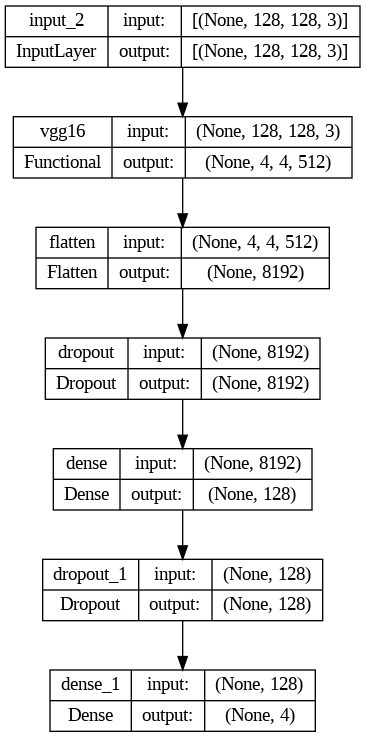

In [11]:
keras.utils.plot_model(first_model, show_shapes=True)

In [ ]:
# partially from ChatGPT
#batch_size=20

# Create an instance of the ImageDataGenerator
#datagen_train = ImageDataGenerator(rescale=1./255)

#datagen_test = ImageDataGenerator(rescale=1./255)
# Load the training data
#train_generator = datagen_train.flow_from_directory('/content/drive/MyDrive/Neuro 140 Final Project/brain_mri_dataset/Training',
                                               #target_size=(image_size, image_size),
                                               #batch_size=batch_size,
                                               #class_mode='categorical')

# Load the validation data
#test_generator = datagen_test.flow_from_directory('/content/drive/MyDrive/Neuro 140 Final Project/brain_mri_dataset/Testing',
                                             #target_size=(image_size, image_size),
                                             #batch_size=batch_size,
                                             #class_mode='categorical')

In [ ]:
batch_size = 20
steps = int(len(train_path)/batch_size)
epochs = 10
history = first_model.fit(datagen(train_path, train_classification, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/10
  1/285 [..............................] - ETA: 35:16 - loss: 1.9283 - sparse_categorical_accuracy: 0.2000

In [ ]:
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=3)
plt.plot(history.history['loss'], '.r-', linewidth=3)
plt.titel('First Model Training Results')
plt.xlabel('epoch')
plt.ylabel('percentage value')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left')
plt.show()

NameError: ignored

In [12]:
second_general_model = ResNet50(input_shape=(image_size,image_size,3), include_top=False, weights='imagenet')
# set beginning layers to non-trainable to retain pre-trained weights from imagenet

for layer in general_model.layers:
    layer.trainable=False

# set last block to trainable for new dataset
second_general_model.layers[-2].trainable=True
second_general_model.layers[-3].trainable=True
second_general_model.layers[-4].trainable=True

# first CNN model
second_model = Sequential()
second_model.add(Input(shape=(image_size,image_size,3)))
second_model.add(general_model)
second_model.add(Flatten())
second_model.add(Dropout(0.2))
second_model.add(Dense(units=128, activation='relu'))
second_model.add(Dropout(0.2))
second_model.add(Dense(units=4, activation='softmax'))

94765736/94765736 [==============================] - 1s 0us/step


In [13]:
second_model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics='sparse_categorical_accuracy')

In [14]:
batch_size = 20
steps = int(len(train_path)/batch_size)
epochs = 5
second_history = second_model.fit(datagen(train_path, train_classification, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/5
285/285 [==============================] - 1960s 7s/step - loss: 0.5048 - sparse_categorical_accuracy: 0.8026
Epoch 2/5
285/285 [==============================] - 1186s 4s/step - loss: 0.3265 - sparse_categorical_accuracy: 0.8742
Epoch 3/5
285/285 [==============================] - 1170s 4s/step - loss: 0.2736 - sparse_categorical_accuracy: 0.8904
Epoch 4/5
285/285 [==============================] - 1166s 4s/step - loss: 0.2380 - sparse_categorical_accuracy: 0.9074
Epoch 5/5
285/285 [==============================] - 1162s 4s/step - loss: 0.2124 - sparse_categorical_accuracy: 0.9171


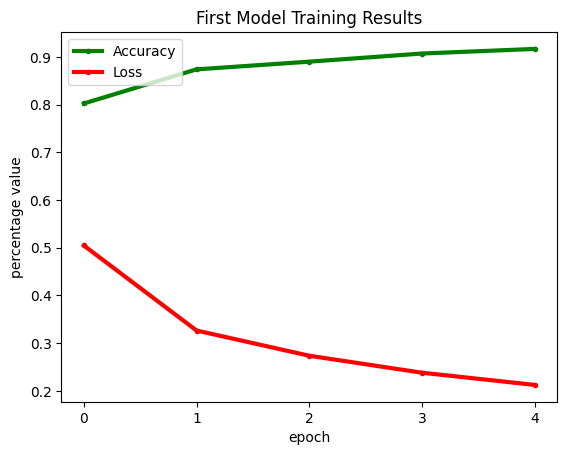

In [17]:
plt.plot(second_history.history['sparse_categorical_accuracy'], '.g-', linewidth=3)
plt.plot(second_history.history['loss'], '.r-', linewidth=3)
plt.title('First Model Training Results')
plt.xlabel('epoch')
plt.ylabel('percentage value')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left')
plt.show()